In [1]:
import torch
from torch import nn
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms 
from PIL import Image 
import os
from tqdm import tqdm
import random
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

C:\Users\mihai\anaconda3\envs\gpu_env\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
videos_path = r'C:\Users\mihai\Desktop\forehand-analysis\images_datasets\images_dataset_cnn'

In [3]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((385, 422)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=videos_path, transform=transform)
dataset

Dataset ImageFolder
    Number of datapoints: 110
    Root location: C:\Users\mihai\Desktop\forehand-analysis\images_datasets\images_dataset_cnn
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(385, 422), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [4]:
# img, label = dataset[124]
# img_height = img.shape[1]
# img_width = img.shape[2]
# print(img.shape)
# plt.imshow(img.numpy().reshape(img_height, img_width), cmap='gray')

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Conv2d(1, 16, 3) 
        self.layer2 = nn.Conv2d(16, 32, 3)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten(start_dim=1)
        self.activation = nn.ReLU()
        self.layer3 = nn.Linear(312832, 128)
        self.fc = nn.Linear(128, 1)
        #self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        #print(x.shape)
        x = self.activation(self.layer1(x))
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = self.activation(self.layer2(x))
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.activation(self.layer3(x))
        #print(x.shape)
        x = self.fc(x)
        return x.squeeze(1)

In [6]:
model = ConvNet()

In [7]:
#model(img.reshape(1,1,img_height,img_width)) # dodajemo batch_size=1

In [8]:
loss_fn = BCEWithLogitsLoss()
optimizer = Adam(model.parameters())
device = 'gpu' if torch.cuda.is_available() else 'cpu'
model.to(device)

ConvNet(
  (layer1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (layer2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (activation): ReLU()
  (layer3): Linear(in_features=312832, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [9]:
#other_test_indices = list(range(43, 53)) + list(range(101, 108)) + list(range(156, 163))

In [10]:
other_test_indices = list(range(48, 55)) + list(range(103, 110))
dataset_indices = [x for x in range(len(dataset)) if x not in other_test_indices]
dataset_labels = [dataset.targets[i] for i in dataset_indices]

#dataset_indices

In [11]:
random_state=42

In [12]:
whole_train_idx, test_idx = train_test_split(dataset_indices, test_size=30, stratify=dataset_labels, random_state=random_state)
test_dataset = Subset(dataset, test_idx)
len(test_dataset)

30

In [13]:
whole_train_dataset = Subset(dataset, whole_train_idx)
wtd_labels = [dataset.targets[i] for i in whole_train_idx]
#print(wtd_labels)
train_idx, val_idx = train_test_split(whole_train_idx, test_size=15, stratify=wtd_labels, random_state=random_state)
val_dataset = Subset(dataset, val_idx)
len(val_dataset)

15

In [14]:
train_dataset = Subset(dataset, train_idx)
len(train_dataset)

51

In [15]:
other_test_dataset = Subset(dataset, other_test_indices)
len(other_test_dataset)

14

In [16]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)
test_loader = DataLoader(test_dataset, batch_size=4)
other_test_loader = DataLoader(other_test_dataset, batch_size=4)

In [17]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    model.train()
    
    total_loss = 0
    num_same = 0
    
    for X, y in dataloader:
        X, y = X.to(device), y.to(device, dtype=torch.float32) 
        
        #forward pass
        outputs = model(X)
        loss = loss_fn(outputs, y)
        total_loss += loss.item()
        
        if len(outputs.shape) == 1: # accuracy - dve klase
            preds = outputs > 0
            num_same += sum(preds == y).item()
                
        else: # accuracy - vise klasa
            _, indices = torch.max(outputs, 1)
            num_same += sum(indices == y).item()
        
        #backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    avg_loss = total_loss / len(dataloader.dataset)
    acc = num_same / len(dataloader.dataset)
    return avg_loss, acc

In [18]:
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    
    with torch.no_grad():
        total_loss = 0
        num_same = 0
        
        for X, y in dataloader:
            X, y = X.to(device), y.to(device, dtype=torch.float32) 
            
            outputs = model(X)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()

            if len(outputs.shape) == 1: # accuracy - dve klase
                preds = outputs > 0
                print(outputs)
                print(preds, " : ", y)
                num_same += sum(preds == y).item()
                
            else: # accuracy - vise klasa
                _, indices = torch.max(outputs, 1)
                print(outputs)
                print(indices, " : ", y)
                num_same += sum(indices == y).item()
        
        avg_loss = total_loss / len(dataloader.dataset)
        acc = num_same / len(dataloader.dataset)
        print(f'Average loss: {avg_loss}')
        print(f'Accuracy: {acc}')
        print()
        
        return avg_loss, acc

In [19]:
num_epochs = 20
train_losses, train_accs = [], []
val_losses, val_accs = [], []

best_val_acc = float('-inf')
last_val_acc = float('-inf')
best_model_weights = model.state_dict()
best_epoch = -1

for epoch in tqdm(range(num_epochs)):
    train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    val_loss, val_acc = test_loop(val_loader, model, loss_fn, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    if val_acc > best_val_acc and val_acc == last_val_acc:
        #print(val_acc)
        best_val_acc = val_acc
        best_model_weights = model.state_dict()
        torch.save(best_model_weights, './models/best_model_cnn.pth')
        best_epoch = epoch

    last_val_acc = val_acc
    
print(val_acc, ' : ', best_val_acc)
if best_val_acc < val_acc:
    best_epoch = epoch
    torch.save(model.state_dict(), './models/best_model_cnn.pth')

  5%|████▏                                                                              | 1/20 [00:05<01:47,  5.64s/it]

tensor([3.0747, 3.1406, 3.0867, 3.0917])
tensor([True, True, True, True])  :  tensor([0., 1., 0., 0.])
tensor([3.1239, 3.1241, 3.0913, 3.0872])
tensor([True, True, True, True])  :  tensor([0., 1., 1., 0.])
tensor([3.1169, 3.1189, 3.0976, 3.1341])
tensor([True, True, True, True])  :  tensor([1., 1., 0., 1.])
tensor([3.0956, 3.1185, 3.0958])
tensor([True, True, True])  :  tensor([0., 1., 0.])
Average loss: 0.45862733125686644
Accuracy: 0.4666666666666667

tensor([0.0352, 0.4615, 0.1094, 0.1508])
tensor([True, True, True, True])  :  tensor([0., 1., 0., 0.])
tensor([0.3955, 0.2630, 0.2277, 0.1973])
tensor([True, True, True, True])  :  tensor([0., 1., 1., 0.])
tensor([0.3002, 0.3253, 0.1814, 0.3509])
tensor([True, True, True, True])  :  tensor([1., 1., 0., 1.])
tensor([0.1006, 0.3827, 0.2325])
tensor([True, True, True])  :  tensor([0., 1., 0.])
Average loss: 0.17961227496465046
Accuracy: 0.4666666666666667



 15%|████████████▍                                                                      | 3/20 [00:15<01:29,  5.27s/it]

tensor([-1.0235,  0.4790, -0.8446, -0.6747])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([ 0.1263, -0.2795, -0.4567, -0.5384])
tensor([ True, False, False, False])  :  tensor([0., 1., 1., 0.])
tensor([-0.1645, -0.0546, -0.6063,  0.0082])
tensor([False, False, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([-0.8311,  0.0576, -0.3760])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.1542574922243754
Accuracy: 0.6666666666666666

tensor([-0.4056,  3.7889,  0.2714,  0.9140])
tensor([False,  True,  True,  True])  :  tensor([0., 1., 0., 0.])
tensor([3.2467, 2.3070, 1.7174, 1.3611])
tensor([True, True, True, True])  :  tensor([0., 1., 1., 0.])
tensor([2.6546, 2.7740, 1.0785, 2.8085])
tensor([True, True, True, True])  :  tensor([1., 1., 0., 1.])
tensor([0.2804, 3.1884, 1.8051])
tensor([True, True, True])  :  tensor([0., 1., 0.])
Average loss: 0.2183790405591329
Accuracy: 0.5333333333333333



 25%|████████████████████▊                                                              | 5/20 [00:25<01:14,  5.00s/it]

tensor([-4.5695,  3.9952, -3.6750, -2.0354])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([ 1.7813, -0.6312, -0.4697, -0.8944])
tensor([ True, False, False, False])  :  tensor([0., 1., 1., 0.])
tensor([ 1.3491,  0.7678, -2.3228,  1.0080])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([-3.8298,  2.6626, -0.0685])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.10805963029464086
Accuracy: 0.8

tensor([-7.3487,  6.1421, -5.8171, -3.6224])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([ 2.2530, -1.1054, -0.9505, -1.4445])
tensor([ True, False, False, False])  :  tensor([0., 1., 1., 0.])
tensor([ 1.7778,  0.6170, -3.8120,  1.1013])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([-6.3510,  3.9057, -0.8275])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.11124131803711255
Accuracy: 0.8



 30%|████████████████████████▉                                                          | 6/20 [00:30<01:09,  4.99s/it]

tensor([-8.5632,  8.2225, -6.6278, -3.9283])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([ 2.3405, -1.3121, -0.6445, -1.2189])
tensor([ True, False, False, False])  :  tensor([0., 1., 1., 0.])
tensor([ 2.2892,  0.8600, -3.9592,  1.3530])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([-7.5396,  4.9756, -0.9831])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.10769138683875402
Accuracy: 0.8



 40%|█████████████████████████████████▏                                                 | 8/20 [00:42<01:06,  5.52s/it]

tensor([-8.5387, 10.3352, -6.2917, -3.4522])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([ 3.7280,  0.0208,  0.4209, -0.3462])
tensor([ True,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ 3.6583,  2.1129, -3.0831,  2.5748])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([-7.1559,  6.5447, -0.3483])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.10800594861308734
Accuracy: 0.9333333333333333

tensor([-11.7252,   9.0626,  -9.0717,  -6.3181])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([ 1.9005, -2.1676, -1.8381, -2.9366])
tensor([ True, False, False, False])  :  tensor([0., 1., 1., 0.])
tensor([ 1.6189,  0.0911, -5.4928,  0.5671])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])


 45%|█████████████████████████████████████▎                                             | 9/20 [00:48<01:01,  5.58s/it]

tensor([-10.0024,   4.8980,  -3.0990])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.128446055300689
Accuracy: 0.8

tensor([-11.2600,   9.3993,  -8.4675,  -5.7542])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([ 2.7838, -1.3860, -1.0412, -2.4033])
tensor([ True, False, False, False])  :  tensor([0., 1., 1., 0.])
tensor([ 2.3818,  0.8666, -4.8062,  1.3564])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])


 50%|█████████████████████████████████████████                                         | 10/20 [00:54<00:56,  5.66s/it]

tensor([-9.3703,  5.7295, -2.6433])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.11098580223042517
Accuracy: 0.8

tensor([-10.8402,   9.8315,  -8.0141,  -5.2889])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([ 3.4149, -0.8157, -0.4141, -1.9675])
tensor([ True, False, False, False])  :  tensor([0., 1., 1., 0.])
tensor([ 3.0596,  1.4394, -4.3051,  1.9285])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])


 55%|█████████████████████████████████████████████                                     | 11/20 [00:59<00:51,  5.68s/it]

tensor([-8.8958,  6.3531, -2.2306])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.10388812938084205
Accuracy: 0.8

tensor([-11.0725,  10.0527,  -8.1757,  -5.4287])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([ 3.5894, -0.8076, -0.3472, -2.0527])
tensor([ True, False, False, False])  :  tensor([0., 1., 1., 0.])
tensor([ 3.2407,  1.5001, -4.3905,  2.0180])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])


 60%|█████████████████████████████████████████████████▏                                | 12/20 [01:06<00:46,  5.86s/it]

tensor([-9.0830,  6.4991, -2.2396])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.1052372304800277
Accuracy: 0.8

tensor([-11.4732,  10.2855,  -8.5029,  -5.7341])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([ 3.5956, -0.9742, -0.4815, -2.2804])
tensor([ True, False, False, False])  :  tensor([0., 1., 1., 0.])
tensor([ 3.2249,  1.4069, -4.6206,  1.9515])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [01:11<00:40,  5.83s/it]

tensor([-9.4398,  6.4928, -2.4519])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.10822450234166657
Accuracy: 0.8

tensor([-11.8413,  10.6631,  -8.8164,  -6.0302])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([ 3.5840, -1.1298, -0.5967, -2.4980])
tensor([ True, False, False, False])  :  tensor([0., 1., 1., 0.])
tensor([ 3.2301,  1.3075, -4.8319,  1.8850])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [01:17<00:35,  5.85s/it]

tensor([-9.7814,  6.5212, -2.6530])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.11097297303300972
Accuracy: 0.8

tensor([-12.1028,  10.7614,  -9.0350,  -6.2445])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([ 3.5676, -1.2444, -0.6861, -2.6607])
tensor([ True, False, False, False])  :  tensor([0., 1., 1., 0.])
tensor([ 3.2329,  1.2202, -4.9754,  1.8303])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [01:23<00:29,  5.93s/it]

tensor([-10.0298,   6.5350,  -2.7059])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.11329561158393821
Accuracy: 0.8

tensor([-12.4511,  10.6418,  -9.3625,  -6.5728])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([ 3.3778, -1.4904, -0.9174, -2.9628])
tensor([ True, False, False, False])  :  tensor([0., 1., 1., 0.])
tensor([ 3.0588,  0.9667, -5.2543,  1.6240])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [01:29<00:23,  5.85s/it]

tensor([-10.3773,   6.3653,  -2.9602])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.1172226657702898
Accuracy: 0.8

tensor([-12.4993,  10.7957,  -9.3835,  -6.5934])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([ 3.4910, -1.4368, -0.8411, -2.9559])
tensor([ True, False, False, False])  :  tensor([0., 1., 1., 0.])
tensor([ 3.1791,  1.0218, -5.2225,  1.7090])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [01:35<00:17,  5.78s/it]

tensor([-10.4174,   6.4958,  -2.9672])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.11686465897946618
Accuracy: 0.8

tensor([-12.4299,  11.0840,  -9.2719,  -6.4918])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([ 3.7525, -1.2487, -0.6217, -2.8253])
tensor([ True, False, False, False])  :  tensor([0., 1., 1., 0.])
tensor([ 3.4521,  1.2292, -5.0668,  1.9265])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [01:41<00:11,  5.99s/it]

tensor([-10.3198,   6.7663,  -2.8527])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.11489776460609089
Accuracy: 0.8

tensor([-12.8427,  10.8867,  -9.6603,  -6.8830])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([ 3.4818, -1.5675, -0.9158, -3.1889])
tensor([ True, False, False, False])  :  tensor([0., 1., 1., 0.])
tensor([ 3.1959,  0.8877, -5.4043,  1.6509])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [01:47<00:05,  5.95s/it]

tensor([-10.7368,   6.5182,  -3.2121])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.11970641552082574
Accuracy: 0.8

tensor([-12.6588,  11.2472,  -9.4537,  -6.6597])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([ 3.8439, -1.2737, -0.5826, -2.9589])
tensor([ True, False, False, False])  :  tensor([0., 1., 1., 0.])
tensor([ 3.5578,  1.1629, -5.1583,  1.9625])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:53<00:00,  5.66s/it]

tensor([-10.5531,   6.8750,  -2.9305])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.11619634588132613
Accuracy: 0.8

0.8  :  0.8


### Images dataset

In [20]:
print(best_epoch)

5


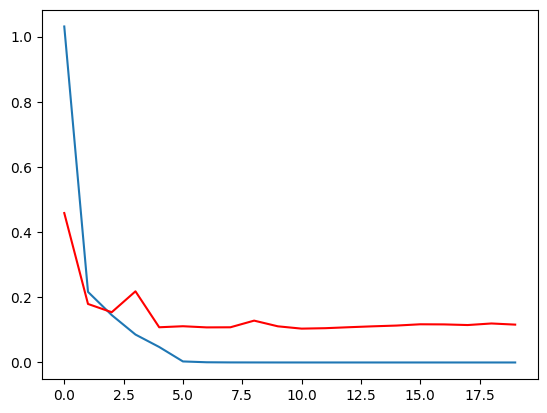

In [21]:
plt.plot(range(num_epochs), train_losses)
plt.plot(range(num_epochs), val_losses, color='red')

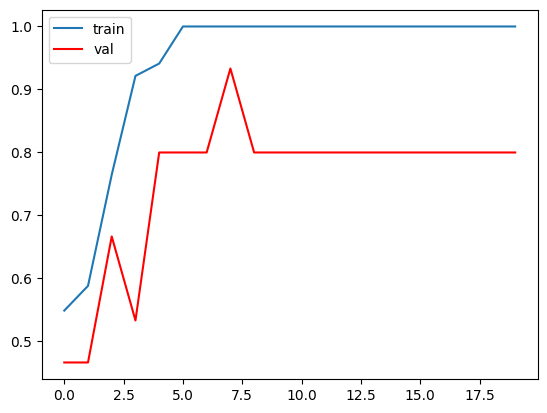

In [22]:
plt.plot(range(num_epochs), train_accs, label='train')
plt.plot(range(num_epochs), val_accs, color='red', label='val')
plt.legend()

In [23]:
model.load_state_dict(torch.load('./models/best_model_cnn.pth'))

<All keys matched successfully>

In [24]:
test_loss, test_acc = test_loop(test_loader, model, loss_fn, device)

tensor([-6.4865, -5.2111,  5.4693,  3.6239])
tensor([False, False,  True,  True])  :  tensor([0., 0., 1., 1.])
tensor([-0.9682,  0.5036, -2.8225, -3.8657])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([-1.3510,  2.0369, -5.5649,  5.8857])
tensor([False,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([ 4.2197, -0.6072,  5.4419,  0.1704])
tensor([ True, False,  True,  True])  :  tensor([1., 0., 1., 1.])
tensor([-2.8109, -6.5312, -2.1669, -0.2291])
tensor([False, False, False, False])  :  tensor([0., 0., 0., 1.])
tensor([-6.8244, -3.5087, -0.6302, -7.5361])
tensor([False, False, False, False])  :  tensor([0., 0., 1., 0.])
tensor([ 3.2582,  4.1562, -5.7709,  0.8988])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([ 1.6536, -2.5045])
tensor([ True, False])  :  tensor([1., 0.])
Average loss: 0.05552116775264342
Accuracy: 0.9



In [25]:
test_idx

[38,
 28,
 71,
 98,
 20,
 56,
 23,
 36,
 58,
 74,
 41,
 90,
 82,
 18,
 79,
 62,
 35,
 47,
 14,
 89,
 2,
 22,
 61,
 7,
 101,
 80,
 42,
 68,
 63,
 10]

In [26]:
other_test_loss, other_test_acc = test_loop(other_test_loader, model, loss_fn, device)

tensor([-3.6796, -5.1218, -3.4854, -4.3299])
tensor([False, False, False, False])  :  tensor([0., 0., 0., 0.])
tensor([-5.7074,  1.8740, -0.6807,  2.7843])
tensor([False,  True, False,  True])  :  tensor([0., 0., 0., 1.])
tensor([-1.2731,  3.4969,  5.6177,  3.4735])
tensor([False,  True,  True,  True])  :  tensor([1., 1., 1., 1.])
tensor([2.2274, 2.2708])
tensor([True, True])  :  tensor([1., 1.])
Average loss: 0.08123278192111424
Accuracy: 0.8571428571428571



In [27]:
other_test_indices

[48, 49, 50, 51, 52, 53, 54, 103, 104, 105, 106, 107, 108, 109]